# Term1 Sprint11 授業課題 
## コーディング課題：ディープニューラルネットワーク(DNN)スクラッチ

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していく。  
前回作成した3層のニューラルネットワークを、クラスを活用することで、任意の構成に拡張しやすいコードに書き換えていく。  
その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていく。  
このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指す。  

**新たなニューラルネットワーク分類器のクラスを作成する**  
Sprint10で作成したものとは別に、ニューラルネットワーク分類器のクラスScratchDeepNeuralNetworkClassifierを作成する。

**層などのクラス化**  
クラスにまとめて行くことで、構成を変更しやすい実装にしていく。  

-手を加える箇所-  
- 層の数
- 層の種類（今後は畳み込み層など他のタイプの層が登場する）
- 活性化関数の種類
- 重みやバイアスの初期化方法
- 最適化手法

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成する。  

## 1. 全結合層のクラス化
**コーディング**

コンストラクタで重みやバイアスの初期化をし、フォワードとバックワードのメソッドを用意する。  
重み$W$、バイアス$B$、およびフォワード時の入力$X$をインスタンス変数として保持しておくことで、煩雑な入出力は不要になる。  

なお、インスタンスも引数として渡すことができる。  
そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われる。  
渡すインスタンスを変えれば、初期化方法が変えられる。

また、引数として自身のインスタンスselfを渡すこともできる。  
これを利用してself = self.optimizer.update(self)として層の重みの更新が可能。  
更新に必要な値は複数あるが、全て全結合層が持つインスタンス変数にすることができる。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyprind
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# データ生成
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train.shape: ", X_train.shape) # (60000, 28, 28)
print("X_test.shape: ", X_test.shape) # (10000, 28, 28)
print("X_train[0].dtype: ", X_train[0].dtype) # uint8

# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train.shape:  (60000, 28, 28)
X_test.shape:  (10000, 28, 28)
X_train[0].dtype:  uint8


In [3]:
# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [4]:
# 訓練データから更に検証データを生成
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print("X_train.shape: ", X_train.shape) # (48000, 784)
print("X_val.shape: ", X_val.shape) # (12000, 784)

X_train.shape:  (48000, 784)
X_val.shape:  (12000, 784)


## 2. 初期化方法のクラス化
前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにする。  
雛形に必要なコードを書き加えていく。  
標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになる。

これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにする。

## 3. 最適化手法のクラス化
最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡す。  
バックワードのときにself = self.optimizer.update(self)のように更新できるようにする。

これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成する。

## 4. 活性化関数のクラス化
活性化関数もクラス化を行う。

class SGDではソフトマックス関数のバックプロパゲーションに交差エントロピー誤差の計算も含む実装を想定している。

## 5. ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装する。  

$$% <![CDATA[
f(x) = ReLU(x) = \begin{cases}
x  & \text{if x>0,}\\
0 & \text{if x<=0.}
\end{cases} %]]>$$

$x$ : ある特徴量。スカラー

実装上はnp.maximumを使い配列に対してまとめて計算が可能。

[numpy.maximum — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.maximum.html "numpy.maximum — NumPy v1.15 Manual")

一方、バックプロパゲーションのための$x$に関する$f(x)$の微分は以下のようになる。

$$% <![CDATA[
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if x>0,}\\
0 & \text{if x<=0.}
\end{cases} %]]>$$

数学的には微分可能ではないが、$x=0$のとき$0$とすることで対応している。  
フォワード時の$x$の正負により、勾配を逆伝播するかどうかが決まるということになる。

## 6. 重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきた。  
しかし、一般的に良い初期値の取り方が知られている。

シグモイド関数やハイパボリックタンジェント関数のときはXavierの初期値（またはGlorotの初期値）、ReLUのときはHeの初期値が使われる。

XavierInitializerクラスと、HeInitializerクラスを作成する。

それぞれの初期化方法における$\sigma$は次の式で求められる。

「Xavierの初期値」
$$\sigma = \frac{1}{\sqrt{n}}$$
$n$ : 前の層のノード数

（論文）

[Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf "Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.")

「Heの初期値」
$$\sigma = \sqrt{\frac{2}{n}}$$
$n$ : 前の層のノード数

（論文）

[He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.](https://arxiv.org/pdf/1502.01852.pdf "He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.")

## 7. 最適化手法
**コーディング**

学習率は学習の良し悪しにとって重要なハイパーパラメータであり、これを学習過程で変化させていく方法が現在では一般的。  
様々な手法が提案されているが、今回はその中でも基本的な、AdaGradを実装する。

まず、これまで使ってきたSGDを確認する。
$$W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) $$

$$B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）  
$\frac{\partial L}{\partial W_i}$ : $W_i$に関する損失$L$の勾配  
$\frac{\partial L}{\partial B_i}$ : $B_i$に関する損失$L$の勾配  
$E()$ : ミニバッチ方向にベクトルの平均を計算  

続いて、AdaGradではバイアスの数式は省略するが、重みと同様のことをする。

更新された分だけその重みに対する学習率を徐々に下げていく。

イテレーションごとの勾配の二乗和$H$を保存しておき、その分だけ学習率を小さくする。

学習率は重み一つひとつに対して異なることになる。
$$H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})*E(\frac{\partial L}{\partial W_i})$$

$$W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) $$

$H_i$ : $i$層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）  
$H_i^{\prime}$ : 更新した$H_i$

AdaGradクラスを作成し、上記の数式にもとづいて実装する。

（論文）

[Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf "Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).")

以下で実装する。  
分類器のインスタンス生成時に各種パラメータを汎用的に選択できるように、最適化手法クラスや活性化関数クラスは一般化した。

**作成クラス一覧**
- ScratchDeepNeuralNetworkClassifier
- FullConnLayer
- LearningMethod
- SimpleInitializer
- Activator
- Softmax
- GetMiniBatch

In [5]:
class ScratchDeepNeuralNetworkClassifier:
    """
    3層(入力層も含めると4層)ニューラルネットワーク分類器

    Parameters
    ----------
    n_nodes1 : int (default : 400)
        隠れ層1のノード数
    n_nodes2 : int (default : 200)
        隠れ層2のノード数
    n_epochs : int (default : 10)
        エポック回数
    learning_method : str (default : "SGD")
        学習の際の最適化手法("SGD", "AdaGrad"から選択)
    alpha : float (default : 0.01)
        学習率
    batch_size : int (default : 10)
        ミニバッチサイズ
    sigma : str or float (default : 0.01)
        各層の重み係数の初期値の標準偏差("Xavier", "He"から選択または値を直接入力)
    activation : str (default : "tanh")
        活性化関数 ("sigmoid", "tanh", ReLU"のいずれかを選択)
    random_seed : int (default : None)
        各層の重み係数の初期化および各エポック毎のデータシャッフル用の擬似乱数シード
    verbose : bool (default : True)
        学習過程を出力しない場合はFalseを設定

    Attributes
    ----------
    self.train_cost_ : list
        1エポック毎の訓練データのコスト関数値（交差エントロピー誤差）
    self.val_cost_ : list
        1エポック毎の検証データのコスト関数値（交差エントロピー誤差）
    self.train_accuracy_ : list
        1エポック毎の訓練データの正解率
    self.val_accuracy_ : list
        1エポック毎の検証データの正解率
    """
    def __init__(self, n_nodes1=400, n_nodes2=200, n_epochs=10, 
                 learning_method="SGD", alpha=0.01, batch_size=10, 
                 sigma=0.01, activation="tanh", random_seed=None, verbose=True):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_epochs = n_epochs
        self.learning_method = learning_method
        self.alpha = alpha
        self.batch_size = batch_size
        self.sigma = sigma
        self.activation = activation
        self.random_seed = random_seed # バッチ学習用
        self.random = np.random.RandomState(random_seed) # 重み初期化、各epoch毎のデータシャッフル用
        self.verbose = verbose
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X_train : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y_train : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        # 出力層のノード数、データの特徴量数
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]
        # コスト関数値、正解率の空リストを生成
        self.train_cost_ = []
        self.val_cost_ = []
        self.train_accuracy_ = []
        self.val_accuracy_ = []
        
        # 全結合層のインスタンスを作成
        optimizer = LearningMethod(self.learning_method, self.alpha)
        self.layer1 = FullConnLayer(n_features, self.n_nodes1, 
                                    SimpleInitializer(self.sigma, n_features), optimizer)
        self.layer2 = FullConnLayer(self.n_nodes1, self.n_nodes2, 
                                    SimpleInitializer(self.sigma, self.n_nodes1), optimizer)
        self.layer_out = FullConnLayer(self.n_nodes2, n_output, 
                                       SimpleInitializer(self.sigma, self.n_nodes2), optimizer)
        # 活性化関数のインスタンスを作成
        self.activator1 = Activator(self.activation)
        self.activator2 = Activator(self.activation)
        self.activator_out = Softmax()
        
        # yラベルをOneHotEncoding
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_onehot = enc.fit_transform(y_train[:, np.newaxis])
        y_val_onehot = enc.transform(y_val[:, np.newaxis])
        
        # 学習の進捗バーを設定
        pbar = pyprind.ProgBar(self.n_epochs * (np.ceil(X_train.shape[0] / self.batch_size).astype(np.int)))
        
        # エポック毎に学習を繰り返す
        for i in range(self.n_epochs):
            get_mini_batch = GetMiniBatch(X_train, y_train_onehot, 
                                          batch_size=self.batch_size, seed=self.random_seed)
            
            # 1エポック毎にバッチデータ生成して学習
            for X_train_batch, y_train_batch in get_mini_batch:
                
                # Forward propagation
                z_n1, a_n1, z_n2, a_n2, z_out, a_out = self._forward(X_train_batch)
                
                # Backward propagation
                # grad_z_n3は交差エントロピー誤差とソフトマックスを合わせている
                grad_z_out = self.activator_out.backward(a_out, y_train_batch)
                grad_a_n2 = self.layer_out.backward(grad_z_out)
                grad_z_n2 = self.activator2.backward(grad_a_n2)
                grad_a_n1 = self.layer2.backward(grad_z_n2)
                grad_z_n1 = self.activator1.backward(grad_a_n1)
                # grad_a_n0は使用しないが、重み更新のためbackward実行
                grad_a_n0 = self.layer1.backward(grad_z_n1)
                
                # 進捗バーを更新
                pbar.update()
            
            # 1エポック毎に訓練データのコスト関数値、正解率を記録
            z_n1, a_n1, z_n2, a_n2, z_out, a_out = self._forward(X_train)
            # コスト関数値
            value1 = y_train_onehot * (np.log(a_out + 1e-07)) # ゼロ除算対策
            value2 = (1. - y_train_onehot) * np.log(1. - a_out + 1e-07) # ゼロ除算対策
            train_cost = -np.sum(value1 + value2)
            self.train_cost_.append(train_cost)
            # 正解率
            y_train_pred = self.predict(X_train)
            train_accuracy = (np.sum(y_train == y_train_pred).astype(np.float)) / y_train.shape[0]
            self.train_accuracy_.append(train_accuracy)
            
            # 検証データがあれば同様に記録
            if X_val is not None and y_val is not None:
                z_n1, a_n1, z_n2, a_n2, z_out, a_out = self._forward(X_val)
                # コスト関数値
                value1 = y_val_onehot * (np.log(a_out + 1e-07)) # ゼロ除算対策
                value2 = (1. - y_val_onehot) * np.log(1. - a_out + 1e-07) # ゼロ除算対策
                val_cost = -np.sum(value1 + value2)
                self.val_cost_.append(val_cost)
                # 正解率
                y_val_pred = self.predict(X_val)
                val_accuracy = (np.sum(y_val == y_val_pred).astype(np.float)) / y_val.shape[0]
                self.val_accuracy_.append(val_accuracy)
        
        # 各コスト関数値を平均値で割る
        self.train_cost_ /= (sum(self.train_cost_) / len(self.train_cost_))
        if len(self.val_cost_) > 0:
            self.val_cost_ /= (sum(self.val_cost_) / len(self.val_cost_))
        
        #verboseをTrueにした際は学習過程などを出力
        if self.verbose:
            plt.rcParams["font.size"] = 16
            fig, ax = plt.subplots(1, 2, figsize=(20,9))
            ax[0].plot(np.arange(1, len(self.train_cost_)+1), self.train_cost_, 
                       linewidth=2, linestyle="-", marker="o", color="steelblue", label="Train")
            ax[0].set_xlabel("epoch numbers")
            ax[0].set_ylabel("cost value (averaged)")
            ax[1].plot(np.arange(1, len(self.train_accuracy_)+1), self.train_accuracy_, 
                       linewidth=2, linestyle="-", marker="o", color="steelblue", label="Train")
            ax[1].set_xlabel("epoch numbers")
            ax[1].set_ylabel("accuracy")
            # 検証データも学習したら可視化
            if len(self.val_cost_) > 0:
                ax[0].plot(np.arange(1, len(self.val_cost_)+1), self.val_cost_, 
                           linewidth=2, linestyle="--", marker="o", color="orangered", label="Validation")
                ax[1].plot(np.arange(1, len(self.val_accuracy_)+1), self.val_accuracy_, 
                           linewidth=2, linestyle="--", marker="o", color="orangered", label="Validation")
            ax[0].legend()
            ax[1].legend()
            plt.show()
    
    def predict(self, X_test):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X_test : 次の形のndarray, shape (n_samples, n_features)
            テスト用データの特徴量

        Returns
        -------
        y_pred : 次の形のndarray, shape (n_samples, 1)
            予測ラベル
        """
        z_n1, a_n1, z_n2, a_n2, z_out, a_out = self._forward(X_test)
        return np.argmax(z_out, axis=1) # 出力層への入力値で最大のノード位置を出力
    
    def _forward(self, X):
        # Forward propagation
        z_n1 = self.layer1.forward(X)
        a_n1 = self.activator1.forward(z_n1)
        z_n2 = self.layer2.forward(a_n1)
        a_n2 = self.activator2.forward(z_n2)
        z_out = self.layer_out.forward(a_n2)
        a_out = self.activator_out.forward(z_out)
        return z_n1, a_n1, z_n2, a_n2, z_out, a_out


class FullConnLayer:
    """
    全結合層クラス
    
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : instance
      初期化方法のインスタンス
    optimizer : instance
      最適化手法のインスタンス
    
    Attributes
    ----------
    self.z : 次の形のndarray, shape (batch_size, n_nodes1)
      forwardの際に、後のbackward計算用に保存しておく入力データ
    
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        # initializerのメソッドを使い、self.wとself.bを初期化する
        self.w = initializer.W(n_nodes1, n_nodes2)
        self.b = initializer.B(n_nodes2)
        self.optimizer = optimizer
        # 最適化方法がAdaGradの場合は、学習係数の減衰用のパラメータhも生成しておく
        if self.optimizer.learning_method == "AdaGrad":
            self.h_w = np.zeros((n_nodes1, n_nodes2))
            self.h_b = np.zeros(n_nodes2)
        
    def forward(self, z):
        """
        Parameters
        ----------
        z : 次の形のndarray, shape (batch_size, n_nodes1)
            入力データ
        Returns
        ----------
        a : 次の形のndarray, shape (batch_size, n_nodes2)
            出力データ
        """
        # backward用に入力値zを保存しておく
        self.z = z
        a = np.dot(z, self.w) + self.b
        return a
    
    def backward(self, grad_a):
        """
        Parameters
        ----------
        grad_a : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        grad_z : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.grad_w = np.dot(self.z.T, grad_a)
        self.grad_b = grad_a.sum(axis=0)
        grad_z = np.dot(grad_a, self.w.T)
        # 更新
        self = self.optimizer.update(self)
        return grad_z


class LearningMethod:
    """
    全結合層(FullConnLayerクラス)のコンストラクタに最適化手法のインスタンスとして渡す。
    メソッドupdateで全結合層(layer)の重みを更新する。

    Parameters
    ----------
    learning_method : str
        "SGD", "AdaGrad"のいずれかの文字列
    alpha : float
        学習率
        
    """
    def __init__(self, learning_method, alpha):
        self.learning_method = learning_method
        self.alpha = alpha
    
    def update(self, layer):
        if self.learning_method == "SGD":
            layer.w -= self.alpha * layer.grad_w / layer.z.shape[0]
            layer.b -= self.alpha * layer.grad_b / layer.z.shape[0]
            return layer
        elif self.learning_method == "AdaGrad":
            layer.h_w += layer.grad_w * layer.grad_w
            layer.h_b += layer.grad_b * layer.grad_b
            layer.w -= self.alpha * (1. / (np.sqrt(layer.h_w) + 1e-07)) * layer.grad_w / layer.z.shape[0]
            layer.b -= self.alpha * (1. / (np.sqrt(layer.h_b) + 1e-07)) * layer.grad_b / layer.z.shape[0]
        else:
            raise ValueError("Set \"SGD\" or \"AdaGrad\".")


class SimpleInitializer:
    """
    全結合層(FullConnLayerクラス)のコンストラクタに初期化方法のインスタンスとして渡す。
    メソッドWとBで乱数を用いて初期化する。

    Parameters
    ----------
    sigma : str, float or int
        正規分布の標準偏差の値または"Xavier", "He"のいずれかの文字列
    n : int
        前の層のノード数
        
    """
    def __init__(self, sigma, n):
        if (type(sigma) is float) or (type(sigma) is int):
            self.sigma = float(sigma)
        elif sigma == "Xavier":
            self.sigma = np.sqrt(1. / n)
        elif sigma == "He":
            self.sigma = np.sqrt(2. / n)
        else:
            raise ValueError("Set \"Xavier\" or \"He\" or numerical value (float or int).")
    
    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2)


class Activator:
    """
    活性化関数をまとめたクラス
    
    Parameters
    ----------
    activation : str
        活性化関数の種類 ("sigmoid", "tanh", ReLU"のいずれか)
    
    Attributes
    ----------
    self.a : 次の形のndarray, shape (batch_size, n_nodes2)
      forwardの際に、後のbackward計算用に保存しておく入力データ
    
    """
    def __init__(self, activation):
        self.activation = activation
    
    def forward(self, a):
        # backward用に入力値aを保存しておく
        self.a = a
        if self.activation == "sigmoid":
            sigmoid_range = 34.538776394910684
            a = np.clip(a, -sigmoid_range, sigmoid_range) # オーバーフロー対策
            return 1 / (1 + np.exp(-a))
        elif self.activation == "tanh":
            return np.tanh(a)
        elif self.activation == "ReLU":
            return np.maximum(0, a)
        else:
            raise ValueError("Set \"sigmoid\" or \"tanh\" or \"ReLU\".")
            
    def backward(self, grad_a):
        if self.activation == "sigmoid":
            return grad_a * (self.a * (1. - self.a))
        elif self.activation == "tanh":
            return grad_a * (1. - (np.tanh(self.a))**2)
        elif self.activation == "ReLU":
            derivative = np.where(self.a > 0., 1., 0.)
            return grad_a * derivative
        else:
            raise ValueError("Set \"sigmoid\" or \"tanh\" or \"ReLU\".")

class Softmax:
    """
    出力層のSoftmax関数のクラス
    
    """
    def forward(self, a):
        a_max = np.max(a, axis=1)
        exp_a = np.exp(a - a_max.reshape(-1, 1)) # a_maxはオーバーフロー対策
        sum_exp_a = np.sum(exp_a, axis=1).reshape(-1, 1)
        return exp_a / sum_exp_a
    
    def backward(self, a_out, y):
        return a_out - y


class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    このクラスをニューラルネットワークのクラス内でインスタンス化し、for文を使うことでミニバッチを取り出す

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size=10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    # 1エポック内でのイテレーション回数を返す
    def __len__(self):
        return self._stop

    # 各イテレーションで使うバッチデータを返す
    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = item * self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    # イテレーションのカウント数をゼロにする
    def __iter__(self):
        self._counter = 0
        return self

    # 次のイテレーションで使うバッチデータを返す
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = self._counter * self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

上記のコードを実際に実行してみる。

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 01:43:12


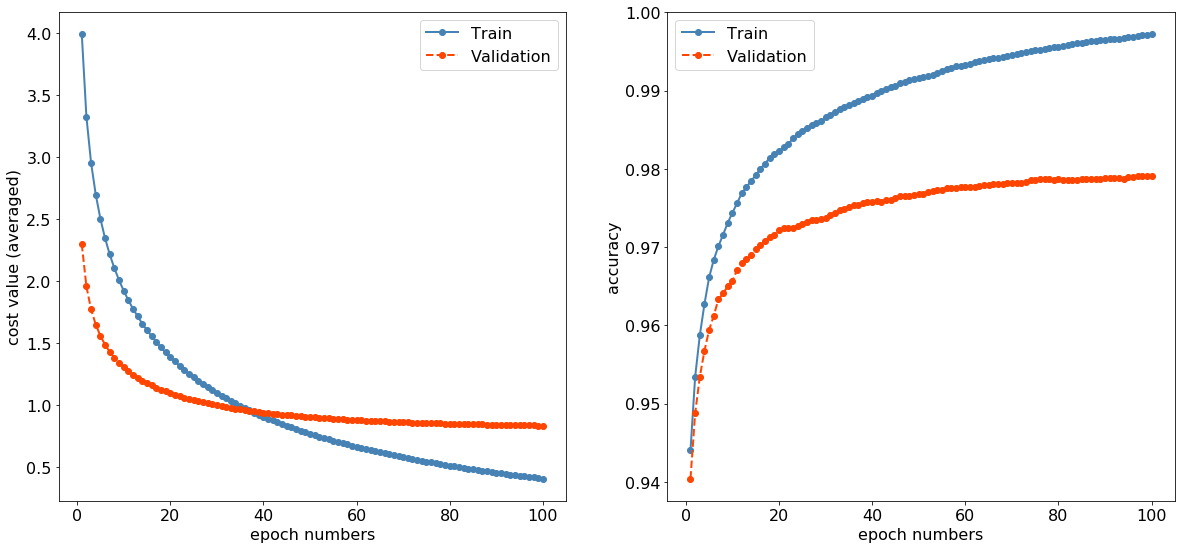

In [11]:
# 実際に実行
scratch_dnnc = ScratchDeepNeuralNetworkClassifier(
    n_nodes1=400, n_nodes2=200, n_epochs=100, learning_method="AdaGrad", alpha=2e-2, 
    batch_size=10, sigma="He", activation="ReLU", random_seed=0, verbose=True)

scratch_dnnc.fit(X_train, y_train, X_val, y_val)

In [12]:
# 最終学習エポックの正解率を出力
final_train_accuracy = scratch_dnnc.train_accuracy_[-1].round(4)
final_val_accuracy = scratch_dnnc.val_accuracy_[-1].round(4)

# 最終学習エポックの推測ラベルを出力
y_train_pred = scratch_dnnc.predict(X_train)
y_val_pred = scratch_dnnc.predict(X_val)

# 正解数を算出
train_accuracy_num = (y_train == y_train_pred).sum()
val_accuracy_num = (y_val == y_val_pred).sum()

# 正解率を出力
print("Final train accuracy: {} ({}/{})".format(final_train_accuracy, train_accuracy_num, len(y_train)))
print("Final validation accuracy: {} ({}/{})".format(final_val_accuracy, val_accuracy_num, len(y_val)))

Final train accuracy: 0.9973 (47869/48000)
Final validation accuracy: 0.9791 (11749/12000)
